# CyAN Cyanobacteria Index (CI_cyano) - 3

In [2]:
import os
os.chdir('/home/jovyan/work/FinalProject')
os.getcwd()

'/home/jovyan/work/FinalProject'

## Apply 0.001 threshold to weekly, monthly, and seasonal CI_cyano

In [ ]:
import os
import rasterio
import numpy as np

# Define input folders
input_folders = [
    "Algal_Data/algal_monthly_spatial",
    "Algal_Data/algal_seasonal_spatial",
    "Algal_Data/Clipped2_Lake_Erie"
]

# Define corresponding output folders
output_folders = [
    "Algal_Data/thresholded_output/algal_monthly_spatial",
    "Algal_Data/thresholded_output/algal_seasonal_spatial",
    "Algal_Data/thresholded_output/algal_weekly_spatial"
]

# Ensure all output folders exist
for folder in output_folders:
    os.makedirs(folder, exist_ok=True)

# Define the threshold value
threshold = 0.001

# Process each input folder
for input_folder, output_folder in zip(input_folders, output_folders):
    # Process all TIFF files in the current folder
    for file in os.listdir(input_folder):
        if file.endswith(".tif"):  # Ensure we only process GeoTIFF files
            input_path = os.path.join(input_folder, file)
            output_path = os.path.join(output_folder, file)  # Save with the same filename in the output folder

            # Open the GeoTIFF file
            with rasterio.open(input_path) as src:
                # Read the first band
                data = src.read(1)
                meta = src.meta  # Metadata for writing output

                # Apply the threshold (set values below threshold to NaN or 0)
                thresholded_data = np.where(data > threshold, data, np.nan)

                # Update metadata for output file
                meta.update(dtype="float32", nodata=np.nan)

                # Write the thresholded data to a new GeoTIFF
                with rasterio.open(output_path, "w", **meta) as dst:
                    dst.write(thresholded_data.astype("float32"), 1)

            print(f"Processed: {input_path} -> {output_path}")

print("Thresholding complete for all files.")

### Visualize individual map

In [ ]:
pip install --upgrade matplotlib

In [7]:
import rasterio
import numpy as np

file_path = "Algal_Data/thresholded_output/algal_monthly_spatial/monthly_avg_2016-08.tif"

# Open the GeoTIFF file
with rasterio.open(file_path) as src:
    data = src.read(1)  # Read the first band
    print(f"Data shape: {data.shape}")
    print(f"Min value: {np.nanmin(data)}")
    print(f"Max value: {np.nanmax(data)}")
    print(f"Unique values: {np.unique(data)}")

Data shape: (789, 1449)
Min value: 0.0010003026109188795
Max value: 0.03230956569314003
Unique values: [0.0010003  0.00100772 0.00100853 ... 0.03162022 0.03230957        nan]


In [8]:
import rasterio

file_path = "Algal_Data/thresholded_output/algal_monthly_spatial/monthly_avg_2016-08.tif"

with rasterio.open(file_path) as src:
    print(f"CRS: {src.crs}")  # Print the CRS
    print(f"Bounds: {src.bounds}")  # Print the geographic bounds

CRS: EPSG:4326
Bounds: BoundingBox(left=-83.5139510628177, bottom=41.00657596279326, right=-78.80098158539533, top=43.57285126830481)


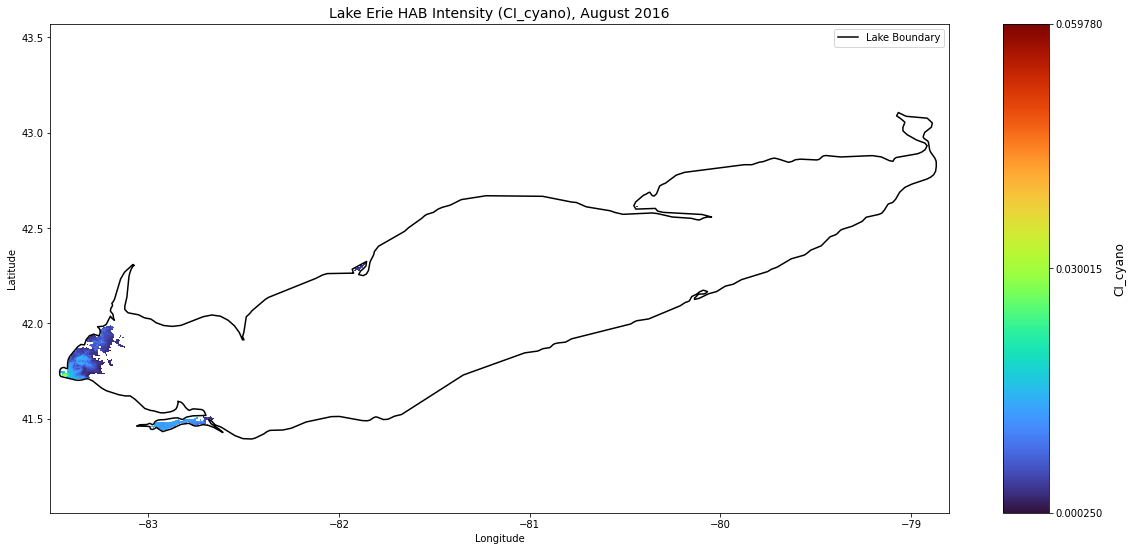

In [9]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from shapely.geometry import shape
import fiona

# Path to the raster file
file_path = "Algal_Data/thresholded_output/algal_monthly_spatial/monthly_avg_2016-08.tif"

# Path to the Lake Erie shapefile
lake_shapefile = "Lakes_Boundary/ne_10m_lakes.shp"

# Open the raster file
with rasterio.open(file_path) as src:
    image = src.read(1)  # Read the first band
    extent = src.bounds  # Get raster bounds for plotting
    raster_crs = src.crs  # Get CRS of the raster file

# Set `0` values to `NaN` to exclude them from the plot
image = np.where(image == 0, np.nan, image)

# Define the color bar range
vmin, vmax = 0.0002504, 0.05978

# Read the Lake Erie boundary from the shapefile using Fiona
lake_erie_boundary = None
with fiona.open(lake_shapefile) as lakes:
    for lake in lakes:
        if lake['properties']['name'] == 'Lake Erie':  # Match the 'name' field to Lake Erie
            lake_erie_boundary = shape(lake['geometry'])
            break

# Check if Lake Erie boundary was found
if lake_erie_boundary is None:
    raise ValueError("Lake Erie boundary not found in the shapefile.")

# Define the colormap
cmap = plt.cm.turbo

# Create a figure with GridSpec for layout control
fig = plt.figure(figsize=(18, 9))
gs = GridSpec(1, 2, width_ratios=[1, 0.05])  # Add space for the vertical color bar

# Plot the raster
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(
    image, cmap=cmap, extent=[extent.left, extent.right, extent.bottom, extent.top],
    origin="upper", vmin=vmin, vmax=vmax  # Set the color bar range
)
ax.set_title('Lake Erie HAB Intensity (CI_cyano), August 2016', fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Overlay Lake Erie boundary
x, y = lake_erie_boundary.exterior.xy  # Extract boundary coordinates
ax.plot(x, y, color='black', linewidth=1.5, label='Lake Boundary')
ax.legend(loc='upper right', fontsize=10)

# Add the color bar on the right
cbar_ax = fig.add_subplot(gs[0, 1])  # Space for the color bar
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('CI_cyano', fontsize=12, labelpad=10)

# Add ticks to match the range
cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])  # Ticks at min, midpoint, and max
cbar.ax.set_yticklabels([f"{vmin:.6f}", f"{((vmin + vmax) / 2):.6f}", f"{vmax:.6f}"], fontsize=10)

# Adjust layout to tighten spacing
plt.subplots_adjust(wspace=0.1)

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


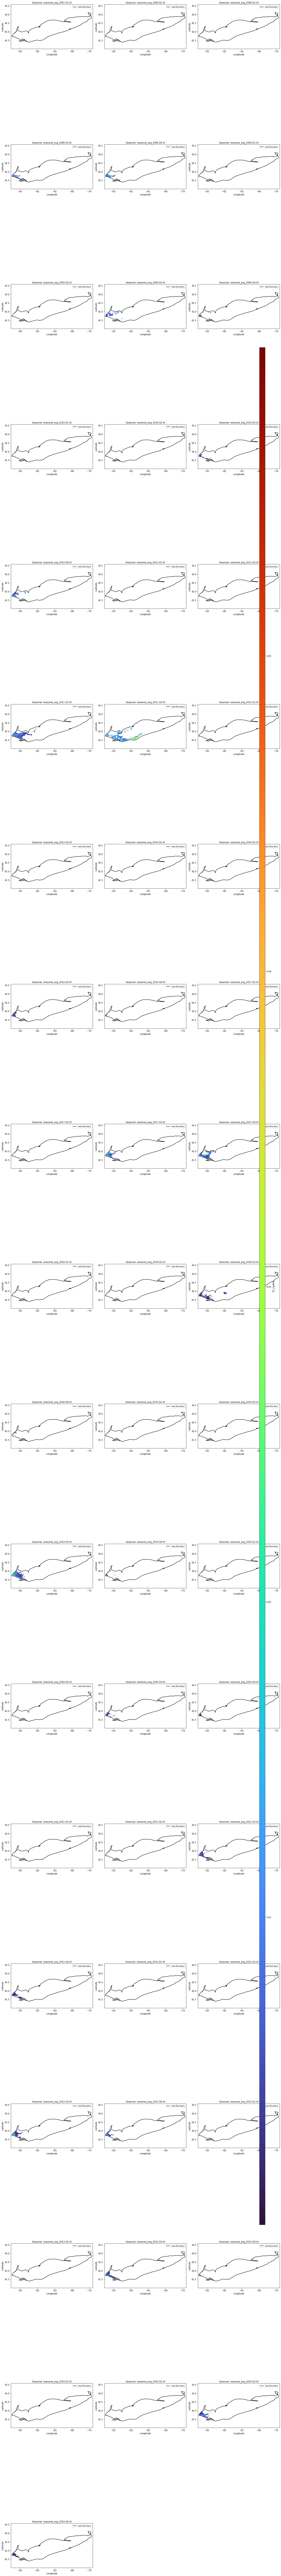

In [1]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from shapely.geometry import shape
import fiona

# Directory containing thresholded GeoTIFF files
folder_path = "Algal_Data/thresholded_output/algal_seasonal_spatial"

# Path to the Lake Erie shapefile
lake_shapefile = "Lakes_Boundary/ne_10m_lakes.shp"

# Define the color bar range
vmin, vmax = 0.0002504, 0.05978

# Define the colormap
cmap = plt.cm.turbo

# Read the Lake Erie boundary from the shapefile using Fiona
lake_erie_boundary = None
with fiona.open(lake_shapefile) as lakes:
    for lake in lakes:
        if lake['properties']['name'] == 'Lake Erie':  # Match the 'name' field to Lake Erie
            lake_erie_boundary = shape(lake['geometry'])
            break

# Check if Lake Erie boundary was found
if lake_erie_boundary is None:
    raise ValueError("Lake Erie boundary not found in the shapefile.")

# Get list of all .tif files in the folder
tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tif")])

# Calculate the number of rows needed (3 columns per row)
n_cols = 3
n_rows = int(np.ceil(len(tif_files) / n_cols))

# Create the figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 9 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each .tif file and plot it
for idx, file in enumerate(tif_files):
    file_path = os.path.join(folder_path, file)
    
    with rasterio.open(file_path) as src:
        image = src.read(1)  # Read the first band
        extent = src.bounds  # Get raster bounds for plotting

    # Set `0` values to `NaN` to exclude them from the plot
    image = np.where(image == 0, np.nan, image)

    # Plot the raster in the corresponding subplot
    ax = axes[idx]
    im = ax.imshow(
        image, cmap=cmap, extent=[extent.left, extent.right, extent.bottom, extent.top],
        origin="upper", vmin=vmin, vmax=vmax  # Set the color bar range
    )
    ax.set_title(f'Seasonal: {file}', fontsize=10)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Overlay Lake Erie boundary
    x, y = lake_erie_boundary.exterior.xy  # Extract boundary coordinates
    ax.plot(x, y, color='black', linewidth=1.5, label='Lake Boundary')
    ax.legend(loc='upper right', fontsize=8)

# Hide any unused subplots
for ax in axes[len(tif_files):]:
    ax.set_visible(False)

# Add the color bar to the right of the figure
fig.subplots_adjust(right=0.9)  # Adjust right boundary for color bar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Color bar location and size
fig.colorbar(im, cax=cbar_ax).set_label('CI_cyano', fontsize=12)

# Adjust layout to tighten spacing
plt.tight_layout()
plt.show()